# Transfer Learning
## Classification of normal and invasive carcinoma samples

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [132]:
# Directories containing the datasets
train_dir = "/kaggle/input/breast-carcinoma/HW6training/HW6training"
validation_dir = "/kaggle/input/breast-carcinoma/HW6validation/HW6validation"
test_dir = "/kaggle/input/breast-carcinoma/HW6testing"

## Data Preprocessing
The preprocessing involves the followig steps.

* Loading the dataset from the directories.

* Resizing the images to 224 x 224.

* View a few samples of the data.

* Applying data augmentation.

* Rescaling the pixel value range.

The MobileNetV2 model expects square image sizes of one of the following [96, 128, 160, 192, 224]
I will use 224 by 224 since the row image size is large enough (512 by 512)


In [133]:
IMAGE_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=16,
    image_size=IMAGE_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=16,
    image_size=IMAGE_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=16,
    image_size=IMAGE_SIZE,
    label_mode=None
)

Found 690 files belonging to 2 classes.
Found 82 files belonging to 2 classes.
Found 149 files.


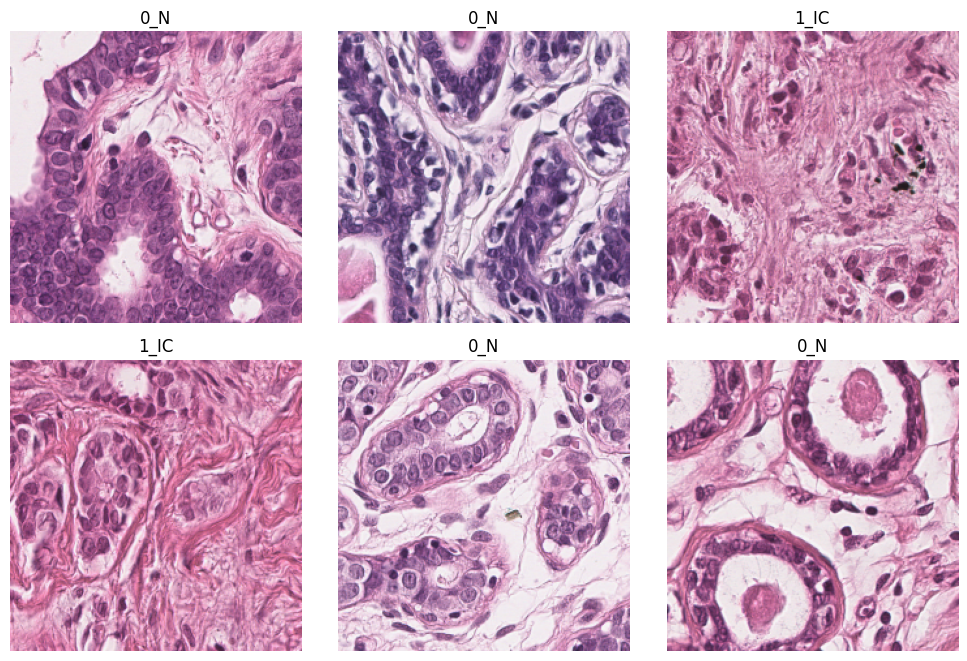

In [164]:
classes = train_dataset.class_names

plt.figure(figsize=(10, 10))

# Extract a single batch of images and labels
batch = next(iter(train_dataset))
images, labels = batch

# Displaying the first 6 images
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(classes[labels[i]])
    ax.axis("off")
plt.tight_layout()
plt.show()

### Data Augmentation
Since the dataset is not large(only 690 images for training) data ugmentation is used to introduce diversity in the dataset and expose the model to different transformations like rotation. This reduces overfitting.

In [135]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

### Pixel values range
The pixel values are in the range of 0 to 255. The model expects values in the range of -1 to 1. The preprocess_input method of the mobilenet_v2 does the rescaling to the required range.

In [136]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Loading Base Model
The 'include_top=False' parameter ensures that we don't use the final classification layer of the model. This is because we only need the features learned by the model and not the final actual classification layer which is specific to the data it was trained on. We will add our own final layer customized to our classication problem.

We use the initial weights the model was trained on(imagenet).
These weights provide a good starting point as the model has already learned useful features like edges, textures, and shapes.

In [137]:
# Base model - MobileNet V2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

In [138]:
# Feature extraction. Converts 224x224x3 images into a 7x7x1280 feature blocks
image_batch, label_batch = next(iter(train_dataset))

# extracted features
feature_batch = base_model(image_batch)

print(feature_batch.shape)

(16, 7, 7, 1280)


### Freezing base model
This prevents the weights of the base model from being updated. At this stage the base model is just being used as a feature extractor.

In [139]:
# Freeze all the layers of the base model
base_model.trainable = False

In [140]:
# View the base model architecture. Note the zero trainable parameters
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Global Average Pooling
GAP reduces the spatial dimensions of feature maps to a single value by calculating the average for each feature channel.
The feature batch shape is (16, 7, 7, 1280) reduced to (16, 1280).

In [141]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# feature batch shape is (16, 7, 7, 1280) reduced to (16, 1280)
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(16, 1280)


## Adding a prediction layer
A final prediction layer outputs the final predictions for the classification.

In [142]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)

## Chaining together the different layers

In [143]:
# Defining the input layer with a shape of (224, 224, 3)
inputs = tf.keras.Input(shape=(224, 224, 3))

# Applying data augmentation
x = data_augmentation(inputs)

# Preprocess the input based on the model's requirements such as pixel value range
x = preprocess_input(x)

# Passing the processed image through the base model
# `training=False` indicates that we are not training the base model only using it for feature extraction
x = base_model(x, training=False)

# Apply GAP to reduce the spatial dimensions
x = global_average_layer(x)

# Adding Dropout layer to prevent overfitting
x = tf.keras.layers.Dropout(0.5)(x)

# Final prediction layer
outputs = prediction_layer(x)

# Full model with inputs and outputs
model = tf.keras.Model(inputs, outputs)


In [144]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_2 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_2 (Subtract)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Note that now we have 1,281 trainable parameters from the added layer.

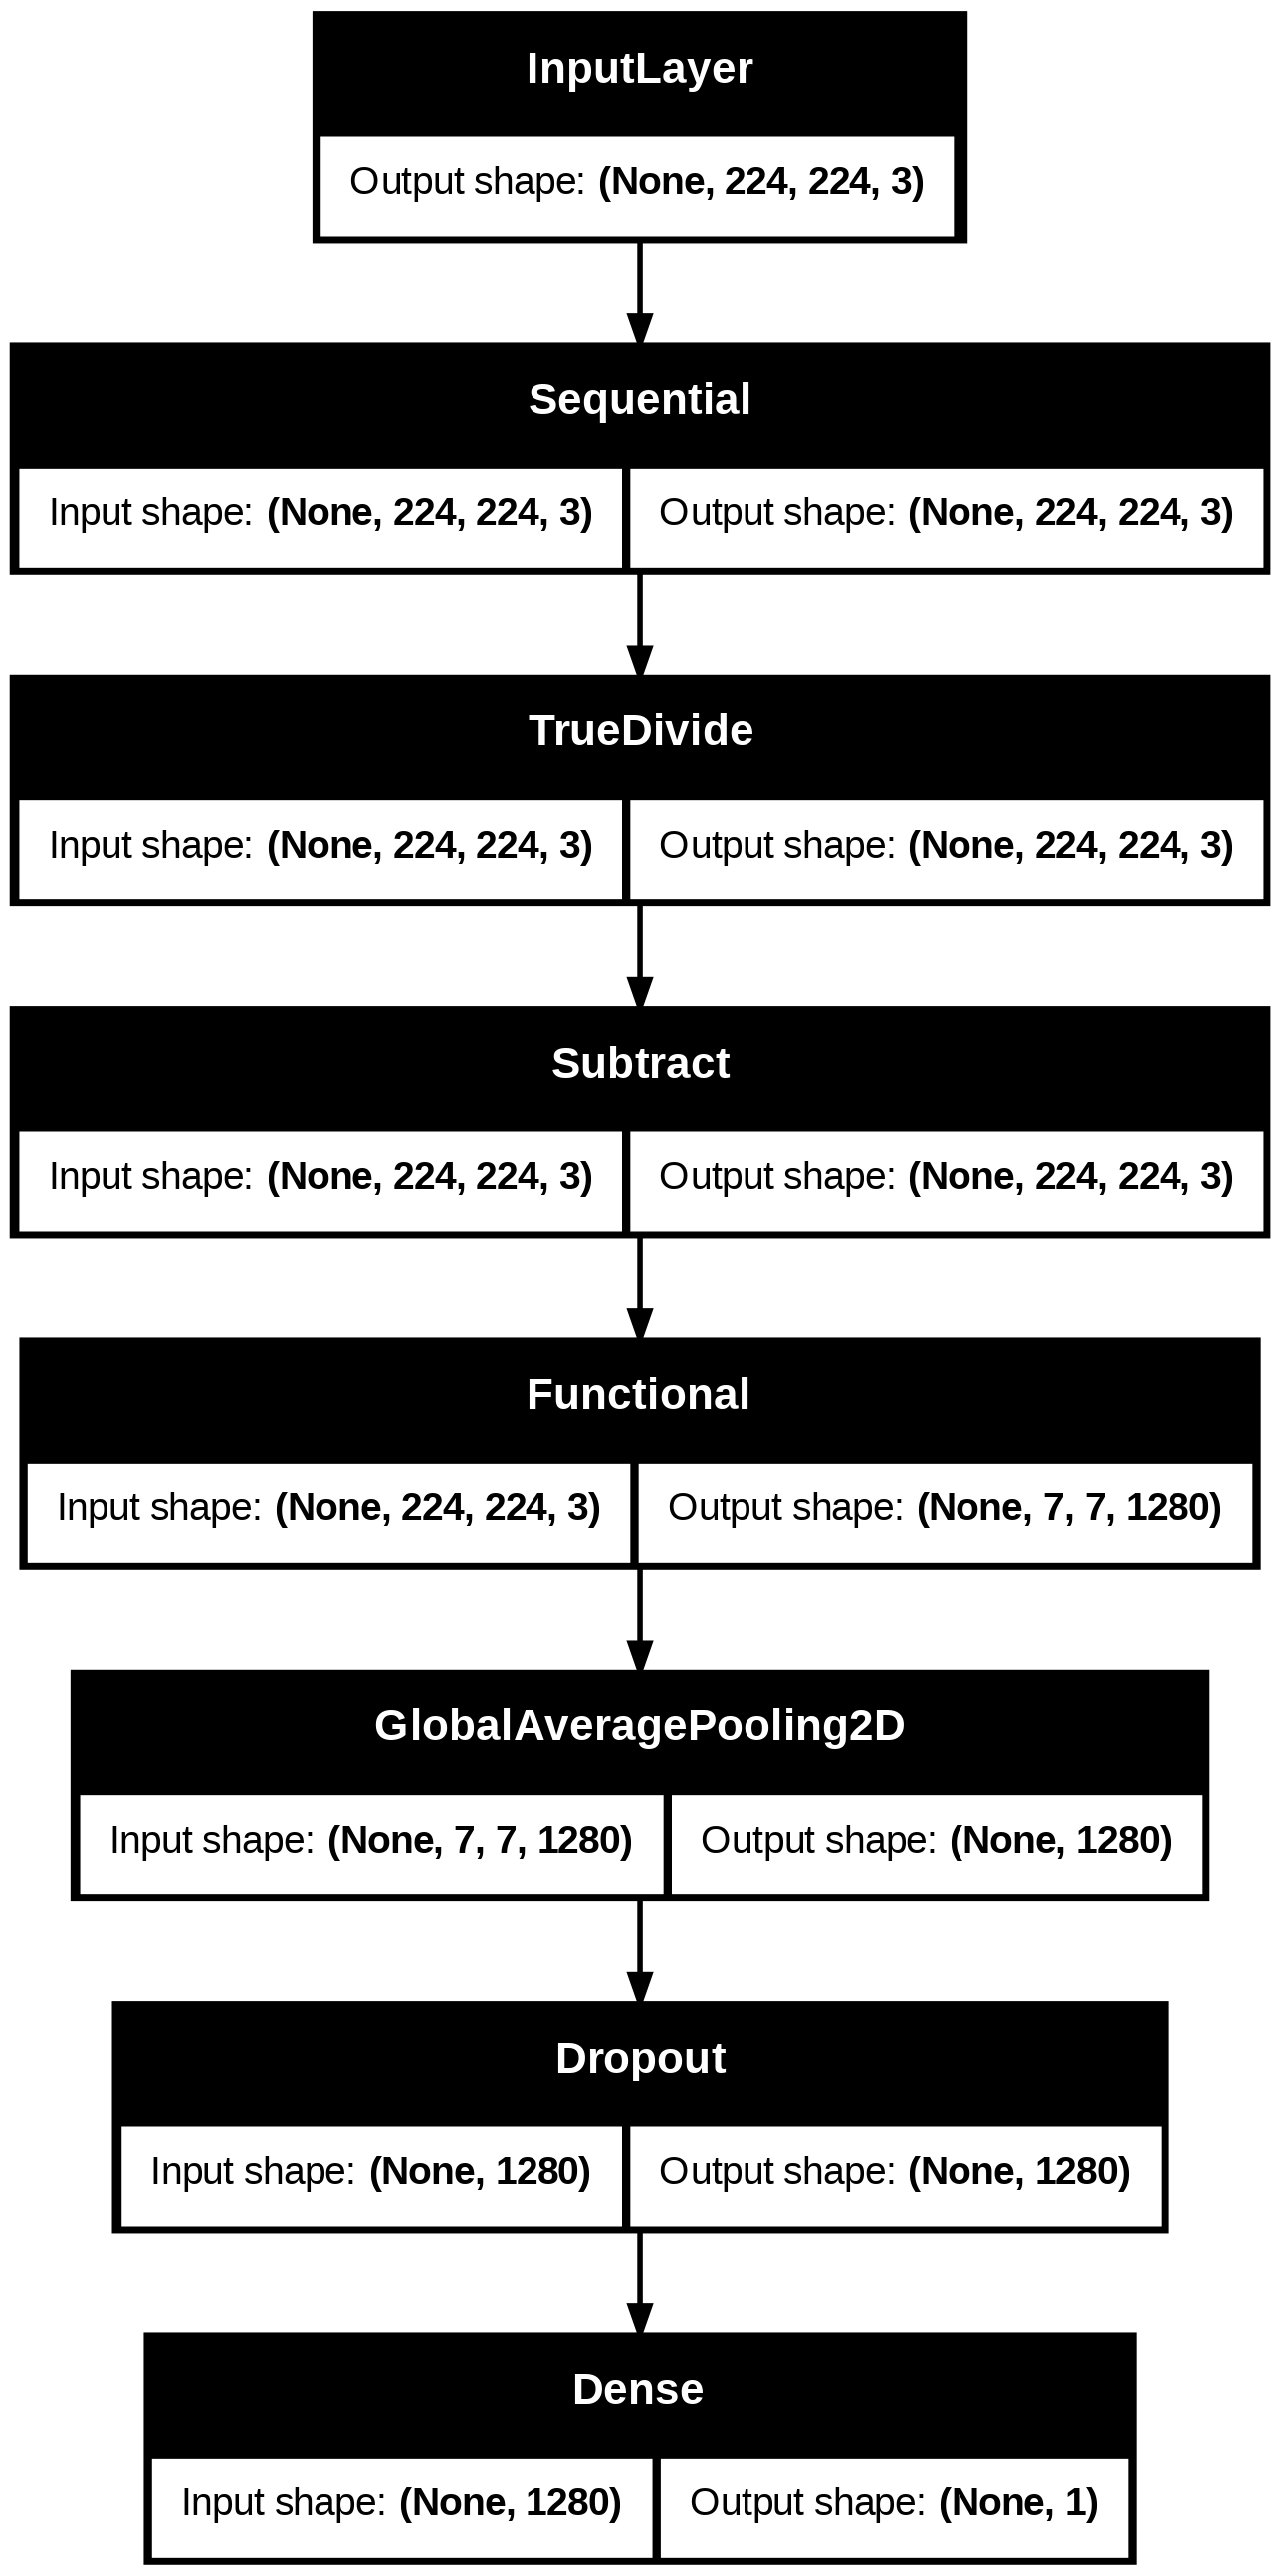

In [145]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Compiling and training
The model is compiled before training.

In [146]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
)

In [147]:
from tensorflow.keras.callbacks import EarlyStopping

# Defining early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will stop
    restore_best_weights=True 
)

# Train the model with early stopping
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.4586 - loss: 0.9473 - val_accuracy: 0.5976 - val_loss: 0.6920
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5421 - loss: 0.8393 - val_accuracy: 0.6220 - val_loss: 0.6572
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5182 - loss: 0.8481 - val_accuracy: 0.6463 - val_loss: 0.6197
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5564 - loss: 0.8047 - val_accuracy: 0.6463 - val_loss: 0.5926
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5798 - loss: 0.7834 - val_accuracy: 0.6707 - val_loss: 0.5630
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.6556 - loss: 0.6431 - val_accuracy: 0.7195 - val_loss: 0.5336
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6317 - loss: 0.6259 - val_accuracy: 0.7317 - val_loss: 0.5207
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6572 - loss: 0.6354 - val_accuracy: 0.7927 - 

### Training and Validation Curves
Both **training and validation accuracy** curves increase over time. They increase initially and then stabilize.

The gap between training and validation accuracy remains relatively small indicating that the model is not overfitting.

The **training and validation loss** curves start high because the model makes many errors at the beginning and decreases over time as the model is getting better at minimizing the error and make better predictions.

The gap between training loss and validation loss is relatively small meaning that the model is not overfitting.

When training loss keeps decreasing but validation loss starts to increase is a sign of overfitting.

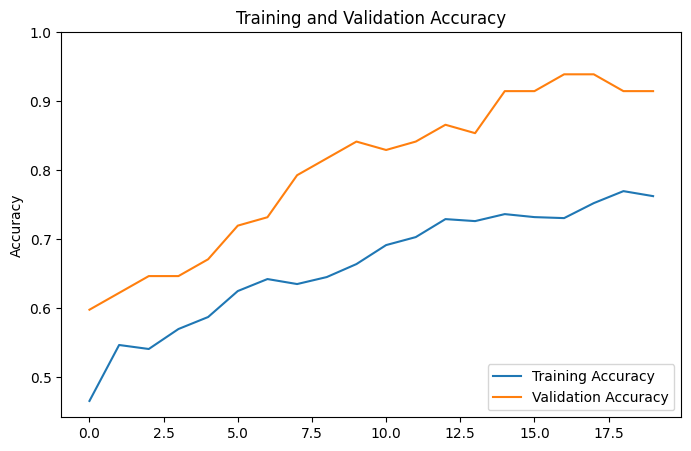

In [148]:
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plotting the metrics
plt.figure(figsize=(8, 5))

# Plotting accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')
plt.show()


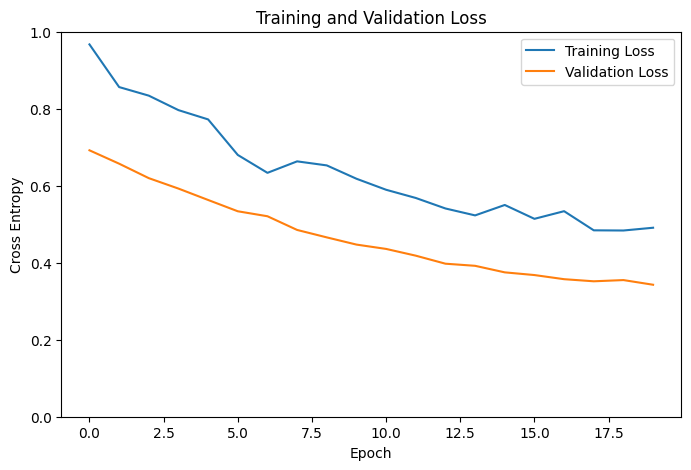

In [149]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

## Fine Tuning
Unfreezing some of the layers of the base model and training them with the dataset can increase accuracy.
Frrezing only the base model layers from first to the 100th layer and training the layers from 100th to 154th with the dataset may lead to slight increase in accuracy.

In [150]:
base_model.trainable = True
# Number of layers in the base model
print("Layers in the base model: ", len(base_model.layers))

Layers in the base model:  154


In [151]:
# Freeze all the layers before the 100th layer. We will train from this layer onwards
for layer in base_model.layers[:100]:
  layer.trainable = False

In [152]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [153]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_2 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_2 (Subtract)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [154]:
history_fine_tuned = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.6654 - loss: 0.6341 - val_accuracy: 0.9146 - val_loss: 0.2989
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.6809 - loss: 0.5615 - val_accuracy: 0.9512 - val_loss: 0.2719
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7678 - loss: 0.4805 - val_accuracy: 0.9512 - val_loss: 0.2508
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8090 - loss: 0.4249 - val_accuracy: 0.9512 - val_loss: 0.2297
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8140 - loss: 0.4230 - val_accuracy: 0.9512 - val_loss: 0.2132
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8487 - loss: 0.3824 - val_accuracy: 0.9512 - val_loss: 0.2057
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8619 - loss: 0.3361 - val_accuracy: 0.9390 - val_loss: 0.1955
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8605 - loss: 0.3335 - val_accuracy: 0.9390 -

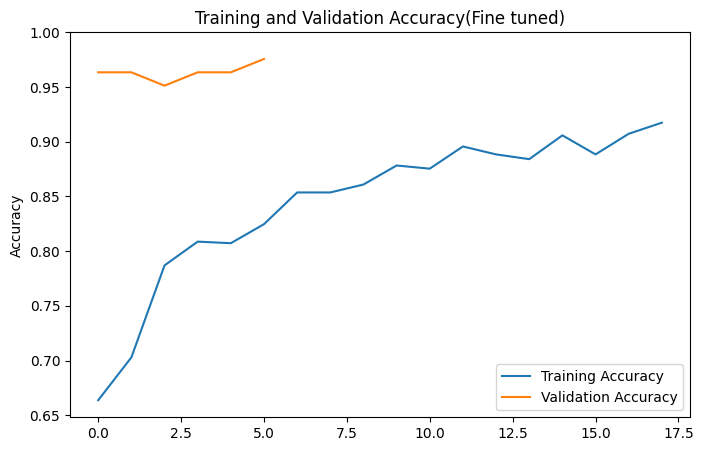

In [155]:
train_accuracy = history_fine_tuned.history['accuracy']
validation_accuracy = history_fine.history['val_accuracy']

# Plotting the metrics
plt.figure(figsize=(8, 5))

# Plotting accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy(Fine tuned)')
plt.show()


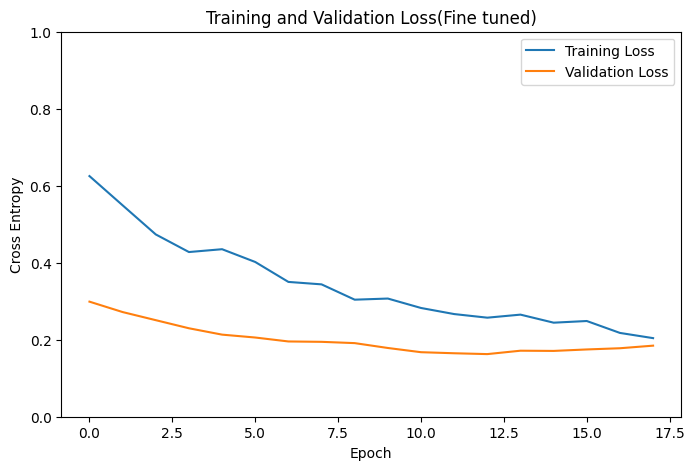

In [156]:
train_loss = history_fine_tuned.history['loss']
validation_loss = history_fine_tuned.history['val_loss']

# Plotting loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss(Fine tuned)')
plt.xlabel('Epoch')
plt.show()

## Predictions on the test dataset

In [157]:
# Generating predictions on the test dataset
predictions = model.predict(test_dataset)

# Converting predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

# Print predictions
print(binary_predictions.flatten())

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step
[1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1
 1]


In [158]:
filenames = sorted(os.listdir('/kaggle/input/breast-carcinoma/HW6testing/HW6testing'))
for filename in filenames:
    print(filename)

UK_1.png
UK_10.png
UK_100.png
UK_101.png
UK_102.png
UK_103.png
UK_104.png
UK_105.png
UK_106.png
UK_107.png
UK_108.png
UK_109.png
UK_11.png
UK_110.png
UK_111.png
UK_112.png
UK_113.png
UK_114.png
UK_115.png
UK_116.png
UK_117.png
UK_118.png
UK_119.png
UK_12.png
UK_120.png
UK_121.png
UK_122.png
UK_123.png
UK_124.png
UK_125.png
UK_126.png
UK_127.png
UK_128.png
UK_129.png
UK_13.png
UK_130.png
UK_131.png
UK_132.png
UK_133.png
UK_134.png
UK_135.png
UK_137.png
UK_138.png
UK_139.png
UK_14.png
UK_140.png
UK_141.png
UK_143.png
UK_144.png
UK_145.png
UK_146.png
UK_148.png
UK_149.png
UK_15.png
UK_150.png
UK_151.png
UK_152.png
UK_153.png
UK_154.png
UK_157.png
UK_159.png
UK_16.png
UK_160.png
UK_161.png
UK_162.png
UK_17.png
UK_18.png
UK_19.png
UK_2.png
UK_20.png
UK_21.png
UK_22.png
UK_23.png
UK_24.png
UK_25.png
UK_26.png
UK_27.png
UK_28.png
UK_29.png
UK_3.png
UK_30.png
UK_31.png
UK_32.png
UK_33.png
UK_34.png
UK_35.png
UK_36.png
UK_37.png
UK_38.png
UK_39.png
UK_4.png
UK_40.png
UK_41.png
UK_42.png
UK_43.p

In [159]:
# Creating a dataframe
predictions_df = pd.DataFrame({"filename": filenames, "label": binary_predictions.flatten()})
pd.set_option('display.max_rows', None)  # Remove row limit
pd.set_option('display.max_columns', None)  # Remove column limit
print(predictions_df)

       filename  label
0      UK_1.png      1
1     UK_10.png      1
2    UK_100.png      1
3    UK_101.png      1
4    UK_102.png      1
5    UK_103.png      1
6    UK_104.png      1
7    UK_105.png      1
8    UK_106.png      0
9    UK_107.png      1
10   UK_108.png      0
11   UK_109.png      0
12    UK_11.png      1
13   UK_110.png      0
14   UK_111.png      0
15   UK_112.png      0
16   UK_113.png      0
17   UK_114.png      0
18   UK_115.png      0
19   UK_116.png      1
20   UK_117.png      0
21   UK_118.png      1
22   UK_119.png      1
23    UK_12.png      0
24   UK_120.png      1
25   UK_121.png      1
26   UK_122.png      1
27   UK_123.png      1
28   UK_124.png      1
29   UK_125.png      1
30   UK_126.png      1
31   UK_127.png      1
32   UK_128.png      1
33   UK_129.png      1
34    UK_13.png      1
35   UK_130.png      1
36   UK_131.png      1
37   UK_132.png      1
38   UK_133.png      1
39   UK_134.png      1
40   UK_135.png      1
41   UK_137.png      1
42   UK_138

In [160]:
# Extract numeric part from filenames and sort
predictions_df['numeric_part'] = predictions_df['filename'].str.extract(r'_(\d+)').astype(int)
predictions_df = predictions_df.sort_values('numeric_part').drop(columns=['numeric_part'])

# Reset index for clean output
predictions_df = predictions_df.reset_index(drop=True)

# Display the entire DataFrame
print(predictions_df)

       filename  label
0      UK_1.png      1
1      UK_2.png      1
2      UK_3.png      1
3      UK_4.png      1
4      UK_5.png      1
5      UK_6.png      1
6      UK_7.png      0
7      UK_8.png      1
8      UK_9.png      1
9     UK_10.png      1
10    UK_11.png      1
11    UK_12.png      0
12    UK_13.png      1
13    UK_14.png      1
14    UK_15.png      1
15    UK_16.png      1
16    UK_17.png      1
17    UK_18.png      1
18    UK_19.png      1
19    UK_20.png      1
20    UK_21.png      1
21    UK_22.png      1
22    UK_23.png      1
23    UK_24.png      1
24    UK_25.png      1
25    UK_26.png      1
26    UK_27.png      1
27    UK_28.png      1
28    UK_29.png      1
29    UK_30.png      0
30    UK_31.png      1
31    UK_32.png      0
32    UK_33.png      1
33    UK_34.png      0
34    UK_35.png      0
35    UK_36.png      0
36    UK_37.png      0
37    UK_38.png      0
38    UK_39.png      0
39    UK_40.png      1
40    UK_41.png      1
41    UK_42.png      1
42    UK_43

In [162]:
# Select the 'label' column
label_column = predictions_df['label']

# Save to a CSV file
predictions_df.to_csv("/kaggle/working/pd.csv", index=False, header=False)